In [1]:
import theano

import cPickle as pkl
import numpy as np

from collections import OrderedDict, defaultdict
from scipy.linalg import norm

import tools
import datasource
from utils import *
from utils import load_params, init_tparams
from model import init_params, build_sentence_encoder, build_image_encoder, build_errors
from datasets import load_dataset
import matplotlib.pyplot as plt

from numpy import linalg as LA
import numpy as np
%matplotlib inline

In [4]:
print 'Loading dataset'
model = tools.load_model('snapshots/visualize_drive5')
model_options = model['options']
model_options['cnn'] = 'finetuned_t200_10crop_lmdb1_bak'
dataset = load_dataset(model_options['data'], cnn=model_options['cnn'], load_train=True)
dev = dataset['dev']    #val set
dev = datasource.Datasource(dev, worddict=model['worddict'])
dev_caps, dev_ims, dev_cap_tps, dev_im_tps = dev.all()


topic_vectors = tools.encode_topics(model, np.eye(200,dtype='float32'))
img_vectors = tools.encode_images(model, dev_ims)
sentence_vectors = tools.encode_sentences(model, dev_caps)

Loading dataset
snapshots/visualize_drive5
Loading model
Loading model parameters...
Compiling sentence encoder...
Compiling image encoder...
Compiling topic encoder...
Compiling error computation...
Packing up...


In [5]:
print(topic_vectors.shape, img_vectors.shape, sentence_vectors.shape)

((200, 1024), (1000, 1024), (5000, 1024))


In [13]:
img_vectors5 = img_vectors.reshape(1000, 1, 1024).repeat(5, axis=1).reshape(5000, 1024)

In [33]:
sentence_vectors1 = sentence_vectors[0:1000]

In [45]:
x = img_vectors5 < 0

In [46]:
print(x.sum())

0


In [13]:
x = np.zeros((6100,1024))
y = np.zeros((6100,))
x[0:100] = topic_vectors
y[0:100] = 1
x[100:1100] = img_vectors
y[100:1100] = 2
x[1100:6100] = sentence_vectors
y[1100:6100] = 3

In [ ]:
import numpy as Math
import pylab as Plot

def Hbeta(D = Math.array([]), beta = 1.0):
	"""Compute the perplexity and the P-row for a specific value of the precision of a Gaussian distribution."""

	# Compute P-row and corresponding perplexity
	P = Math.exp(-D.copy() * beta);
	sumP = sum(P);
	H = Math.log(sumP) + beta * Math.sum(D * P) / sumP;
	P = P / sumP;
	return H, P;


def x2p(X = Math.array([]), tol = 1e-5, perplexity = 30.0):
	"""Performs a binary search to get P-values in such a way that each conditional Gaussian has the same perplexity."""

	# Initialize some variables
	print "Computing pairwise distances..."
	(n, d) = X.shape;
	sum_X = Math.sum(Math.square(X), 1);
	D = Math.add(Math.add(-2 * Math.dot(X, X.T), sum_X).T, sum_X);
	P = Math.zeros((n, n));
	beta = Math.ones((n, 1));
	logU = Math.log(perplexity);

	# Loop over all datapoints
	for i in range(n):

		# Print progress
		if i % 500 == 0:
			print "Computing P-values for point ", i, " of ", n, "..."

		# Compute the Gaussian kernel and entropy for the current precision
		betamin = -Math.inf;
		betamax =  Math.inf;
		Di = D[i, Math.concatenate((Math.r_[0:i], Math.r_[i+1:n]))];
		(H, thisP) = Hbeta(Di, beta[i]);

		# Evaluate whether the perplexity is within tolerance
		Hdiff = H - logU;
		tries = 0;
		while Math.abs(Hdiff) > tol and tries < 50:

			# If not, increase or decrease precision
			if Hdiff > 0:
				betamin = beta[i].copy();
				if betamax == Math.inf or betamax == -Math.inf:
					beta[i] = beta[i] * 2;
				else:
					beta[i] = (beta[i] + betamax) / 2;
			else:
				betamax = beta[i].copy();
				if betamin == Math.inf or betamin == -Math.inf:
					beta[i] = beta[i] / 2;
				else:
					beta[i] = (beta[i] + betamin) / 2;

			# Recompute the values
			(H, thisP) = Hbeta(Di, beta[i]);
			Hdiff = H - logU;
			tries = tries + 1;

		# Set the final row of P
		P[i, Math.concatenate((Math.r_[0:i], Math.r_[i+1:n]))] = thisP;

	# Return final P-matrix
	print "Mean value of sigma: ", Math.mean(Math.sqrt(1 / beta));
	return P;


def pca(X = Math.array([]), no_dims = 50):
	"""Runs PCA on the NxD array X in order to reduce its dimensionality to no_dims dimensions."""

	print "Preprocessing the data using PCA..."
	(n, d) = X.shape;
	X = X - Math.tile(Math.mean(X, 0), (n, 1));
	(l, M) = Math.linalg.eig(Math.dot(X.T, X));
	Y = Math.dot(X, M[:,0:no_dims]);
	return Y;


def tsne(X = Math.array([]), no_dims = 2, initial_dims = 50, perplexity = 30.0):
	"""Runs t-SNE on the dataset in the NxD array X to reduce its dimensionality to no_dims dimensions.
	The syntaxis of the function is Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array."""

	# Check inputs
	if isinstance(no_dims, float):
		print "Error: array X should have type float.";
		return -1;
	if round(no_dims) != no_dims:
		print "Error: number of dimensions should be an integer.";
		return -1;

	# Initialize variables
	X = pca(X, initial_dims).real;
	(n, d) = X.shape;
	max_iter = 1000;
	initial_momentum = 0.5;
	final_momentum = 0.8;
	eta = 500;
	min_gain = 0.01;
	Y = Math.random.randn(n, no_dims);
	dY = Math.zeros((n, no_dims));
	iY = Math.zeros((n, no_dims));
	gains = Math.ones((n, no_dims));

	# Compute P-values
	P = x2p(X, 1e-5, perplexity);
	P = P + Math.transpose(P);
	P = P / Math.sum(P);
	P = P * 4;									# early exaggeration
	P = Math.maximum(P, 1e-12);

	# Run iterations
	for iter in range(max_iter):

		# Compute pairwise affinities
		sum_Y = Math.sum(Math.square(Y), 1);
		num = 1 / (1 + Math.add(Math.add(-2 * Math.dot(Y, Y.T), sum_Y).T, sum_Y));
		num[range(n), range(n)] = 0;
		Q = num / Math.sum(num);
		Q = Math.maximum(Q, 1e-12);

		# Compute gradient
		PQ = P - Q;
		for i in range(n):
			dY[i,:] = Math.sum(Math.tile(PQ[:,i] * num[:,i], (no_dims, 1)).T * (Y[i,:] - Y), 0);

		# Perform the update
		if iter < 20:
			momentum = initial_momentum
		else:
			momentum = final_momentum
		gains = (gains + 0.2) * ((dY > 0) != (iY > 0)) + (gains * 0.8) * ((dY > 0) == (iY > 0));
		gains[gains < min_gain] = min_gain;
		iY = momentum * iY - eta * (gains * dY);
		Y = Y + iY;
		Y = Y - Math.tile(Math.mean(Y, 0), (n, 1));

		# Compute current value of cost function
		if (iter + 1) % 10 == 0:
			C = Math.sum(P * Math.log(P / Q));
			print "Iteration ", (iter + 1), ": error is ", C

		# Stop lying about P-values
		if iter == 100:
			P = P / 4;

	# Return solution
	return Y;


X = x
labels = y
Y = tsne(X, 2, 50, 20.0);

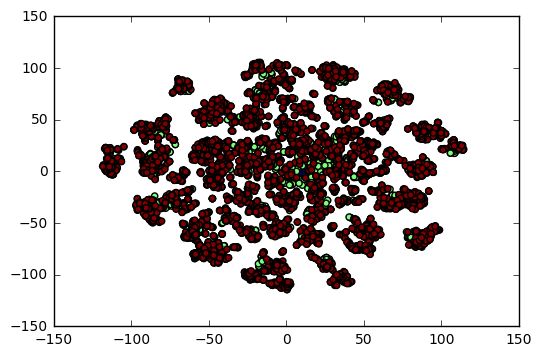

In [25]:
Plot.scatter(Y[0:6100,0], Y[0:6100,1], 20, labels[0:6100]);
Plot.show();

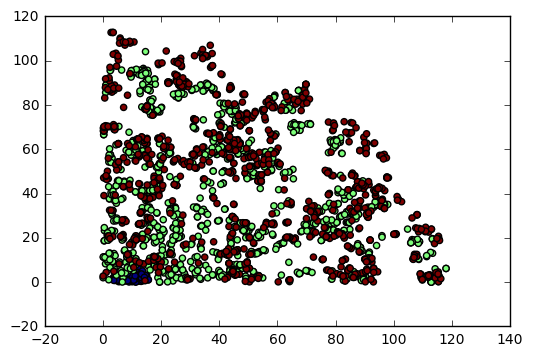

In [24]:
Plot.scatter(Math.abs(Y[0:2100,0]), Math.abs(Y[0:2100,1]), 20, labels[0:2100]);
Plot.show();

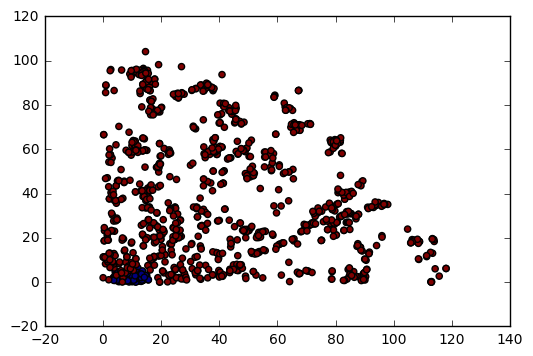

In [26]:
Plot.scatter(Math.abs(Y[0:1100,0]), Math.abs(Y[0:1100,1]), 20, labels[0:1100]);
Plot.show();

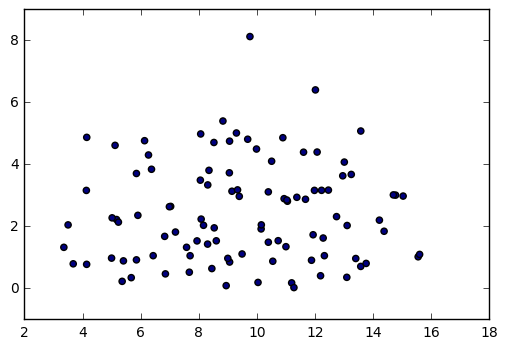

In [27]:
Plot.scatter(Math.abs(Y[0:100,0]), Math.abs(Y[0:100,1]), 20, labels[0:100]);
Plot.show();

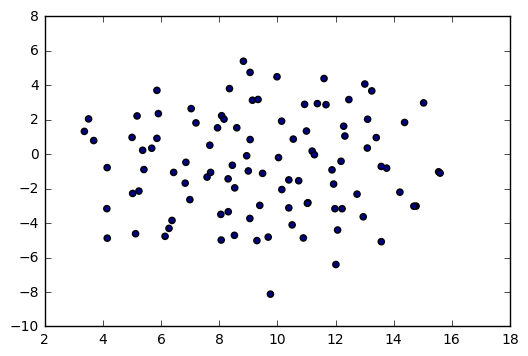

In [16]:
Plot.scatter(Y[0:100,0], Y[0:100,1], 20, labels[0:100]);
Plot.show();

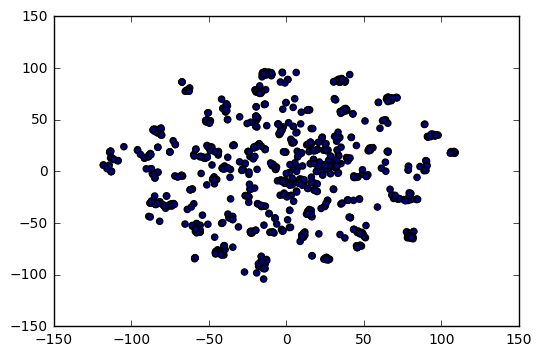

In [17]:
Plot.scatter(Y[100:1100,0], Y[100:1100,1], 20, labels[100:1100]);
Plot.show();

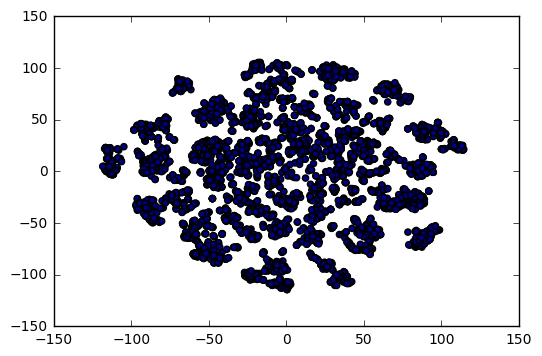

In [18]:
Plot.scatter(Y[1100:6100,0], Y[1100:6100,1], 20, labels[1100:6100]);
Plot.show();

In [10]:
img_tmp = np.load('../neuraltalk2/tmp.npy')
print(img_tmp.shape)
print(tools.encode_images(model, img_tmp))
np.save('../neuraltalk2/tmp2.npy', tools.encode_images(model, img_tmp))

(1, 4096)
[[ 0.          0.          0.01061621 ...,  0.          0.00424775  0.        ]]


In [8]:
for indx in range(50) :
    print(np.argsort(0 - dev_cap_tps[indx])[0:5])
    print(np.argsort(0 - dev_im_tps[indx/5])[0:5])
    print((topic_vectors[dev_cap_tps[indx].argmax()] - sentence_vectors[indx]).sum())
    print((img_vectors[indx/5] - sentence_vectors[indx]).sum())
    if indx % 5 == 4 :
        print('----------------------')

[30 34 61 38 60]
[33 85 18 26 46]
-2.90387
-1.27186
[30 61 85 33 46]
[33 85 18 26 46]
-2.78147
-1.14947
[33 30 38 61  0]
[33 85 18 26 46]
-3.89875
-1.21878
[33 30 38  0 71]
[33 85 18 26 46]
-3.59763
-0.917656
[30 38 61 47  0]
[33 85 18 26 46]
-2.76258
-1.13058
----------------------
[20 97 83 25 40]
[20 81 89  7 97]
-1.44345
-1.2438
[20 81  0 71 70]
[20 81 89  7 97]
-0.596642
-0.396993
[20 69 16 81  0]
[20 81 89  7 97]
-1.07258
-0.87293
[81 20 97  7 91]
[20 81 89  7 97]
-0.722857
-2.00228
[20 81 39 53 29]
[20 81 89  7 97]
-0.890716
-0.691068
----------------------
[87 60 61 79 17]
[18 13 61 60 12]
1.64385
0.311578
[60 61 13  5 48]
[18 13 61 60 12]
-0.124525
-0.766373
[60 13 61 38 29]
[18 13 61 60 12]
1.62455
0.982702
[60 13 61 44 51]
[18 13 61 60 12]
0.670321
0.0284732
[60 13 61 98 18]
[18 13 61 60 12]
0.983164
0.341316
----------------------
[ 7 48  2  0 72]
[48  7 89 95 76]
-1.30824
-0.20013
[48 95  7 89 44]
[48  7 89 95 76]
-1.61996
-0.791783
[89  7 48  0 72]
[48  7 89 95 76]
0.3844

In [12]:
np.save('../neuraltalk2/model/topic_tmp.npy', topic_vectors[0])

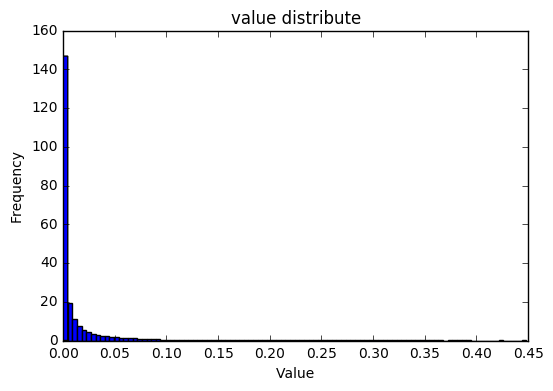

In [52]:
plt.hist(topic_vectors.flatten(), 100, normed=True, histtype='bar')
plt.title("value distribute")
plt.xlabel("Value")
plt.ylabel("Frequency")


plt.hist(sentence_vectors.flatten(), 100, normed=1, histtype='bar')
plt.title("value distribute")
plt.xlabel("Value")
plt.ylabel("Frequency")

plt.hist(img_vectors.flatten(), 100, normed=1, histtype='bar')
plt.title("value distribute")
plt.xlabel("Value")
plt.ylabel("Frequency")

In [2]:
import tools, evaluation
model = tools.load_model('snapshots/sentence-image-finetuned-t200-lmdb1bak-topic-insert_0.2_order_1')
evaluation.ranking_eval_5fold(model, split='test')

snapshots/sentence-image-finetuned-t200-lmdb1bak-topic-insert_0.2_order_1
Loading model
Loading model parameters...
Compiling sentence encoder...


/home/wujian/anaconda2/lib/python2.7/site-packages/theano/scan_module/scan.py:1017: Warning: In the strict mode, all neccessary shared variables must be passed as a part of non_sequences
  'must be passed as a part of non_sequences', Warning)


Compiling image encoder...
Compiling error computation...
Packing up...
Loading fold 0
Computing results...
Text to image: 43.0, 78.6, 89.4, 2.0, 6.1
Image to text: 50.8, 83.6, 91.5, 1.0, 4.1
Loading fold 1
Computing results...
Text to image: 43.0, 77.0, 87.7, 2.0, 6.4
Image to text: 49.8, 83.3, 90.9, 2.0, 5.0
Loading fold 2
Computing results...
Text to image: 41.9, 77.3, 88.8, 2.0, 6.8
Image to text: 49.6, 83.8, 92.9, 2.0, 4.2
Loading fold 3
Computing results...
Text to image: 40.1, 75.7, 88.0, 2.0, 6.7
Image to text: 47.9, 80.7, 89.8, 2.0, 4.6
Loading fold 4
Computing results...
Text to image: 42.8, 78.2, 88.6, 2.0, 6.1
Image to text: 49.8, 81.1, 91.0, 2.0, 4.0
-----------------------------------
Mean metrics: 
Text to image: 42.2, 77.4, 88.5, 2.0, 6.4
Image to text: 49.6, 82.5, 91.2, 1.8, 4.4


In [ ]:
Mean metrics: 
Text to image: 42.3, 77.4, 88.4, 2.0, 6.3
Image to text: 50.0, 82.2, 91.3, 1.4, 4.6
    
Mean metrics: 
Text to image: 42.2, 77.6, 88.5, 2.0, 6.3
Image to text: 51.2, 82.8, 91.3, 1.4, 4.5
    
Mean metrics: 
Text to image: 42.3, 77.4, 88.2, 2.0, 6.4
Image to text: 49.9, 83.1, 91.3, 1.8, 4.6